<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"></ul></div>

# Generative Adversarial Networks <a class="tocSkip">

In [1]:
import os

import numpy as np
np.random.seed(123)
print("NumPy:{}".format(np.__version__))

import pandas as pd
print("Pandas:{}".format(pd.__version__))

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=15,10
print("Matplotlib:{}".format(mpl.__version__))

import tensorflow as tf
tf.set_random_seed(123)
print("TensorFlow:{}".format(tf.__version__))

import keras
print("Keras:{}".format(keras.__version__))

NumPy:1.15.1
Pandas:0.23.4
Matplotlib:2.2.3
TensorFlow:1.10.1
Keras:2.2.2


Using TensorFlow backend.


In [3]:
DATASETSLIB_HOME = '../datasetslib'
import sys
if not DATASETSLIB_HOME in sys.path:
    sys.path.append(DATASETSLIB_HOME)
%reload_ext autoreload
%autoreload 2
import datasetslib

from datasetslib import util as dsu
datasetslib.datasets_root = os.path.join(os.path.expanduser('~'),'datasets')

# Get the MNIST data

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets(os.path.join(datasetslib.datasets_root,'mnist'), one_hot=False)

x_train = mnist.train.images
x_test = mnist.test.images
y_train = mnist.train.labels
y_test = mnist.test.labels

pixel_size = 28

def norm(x):
    return (x-0.5)/0.5

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /home/luis/datasets/mnist/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /home/luis/datasets/mnist/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /home/luis/datasets/mnist/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /home/luis/datasets/mnist/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fro

In [5]:
n_z = 256
z_test = np.random.uniform(-1.0,1.0,size=[8,n_z])

In [6]:
# Function to display the images and labels
def display_images(images):
    for i in range(images.shape[0]):
        plt.subplot(1, 8, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Simple GAN in TensorFlow

In [7]:
tf.reset_default_graph()
keras.backend.clear_session()

In [8]:
# graph hyperparameters
g_learning_rate = 0.00001
d_learning_rate = 0.01

n_x = 784  # number of pixels in the MNIST image as number of inputs

# number of hidden layers for generator and discriminator
g_n_layers = 3
d_n_layers = 1
# neurons in each hidden layer
g_n_neurons = [256, 512, 1024]
d_n_neurons = [256]

# define parameter ditionary
d_params = {}
g_params = {}

activation = tf.nn.leaky_relu
w_initializer = tf.glorot_uniform_initializer
b_initializer = tf.zeros_initializer

# define generator

z_p = tf.placeholder(dtype=tf.float32, name='z_p', shape=[None, n_z])

layer = z_p

# add generator network weights, biases and layers
with tf.variable_scope('g'):
    for i in range(0, g_n_layers):
        w_name = 'w_{0:04d}'.format(i)
        g_params[w_name] = tf.get_variable(
            name=w_name,
            shape=[n_z if i == 0 else g_n_neurons[i - 1], g_n_neurons[i]],
            initializer=w_initializer())

        b_name = 'b_{0:04d}'.format(i)
        g_params[b_name] = tf.get_variable(
            name=b_name, shape=[g_n_neurons[i]], initializer=b_initializer())

        layer = activation(
            tf.matmul(layer, g_params[w_name]) + g_params[b_name])

    #output (logit) layer
    i = g_n_layers
    w_name = 'w_{0:04d}'.format(i)
    g_params[w_name] = tf.get_variable(
        name=w_name,
        shape=[g_n_neurons[i - 1], n_x],
        initializer=w_initializer())

    b_name = 'b_{0:04d}'.format(i)
    g_params[b_name] = tf.get_variable(
        name=b_name, shape=[n_x], initializer=b_initializer())

    g_logit = tf.matmul(layer, g_params[w_name]) + g_params[b_name]
    g_model = tf.nn.tanh(g_logit)

# define discriminator(s)

# add discriminator network weights, biases

with tf.variable_scope('d'):
    for i in range(0, d_n_layers):
        w_name = 'w_{0:04d}'.format(i)
        d_params[w_name] = tf.get_variable(
            name=w_name,
            shape=[n_x if i == 0 else d_n_neurons[i - 1], d_n_neurons[i]],
            initializer=w_initializer())

        b_name = 'b_{0:04d}'.format(i)
        d_params[b_name] = tf.get_variable(
            name=b_name, shape=[d_n_neurons[i]], initializer=b_initializer())

    #output (logit) layer
    i = d_n_layers
    w_name = 'w_{0:04d}'.format(i)
    d_params[w_name] = tf.get_variable(
        name=w_name, shape=[d_n_neurons[i - 1], 1], initializer=w_initializer())

    b_name = 'b_{0:04d}'.format(i)
    d_params[b_name] = tf.get_variable(
        name=b_name, shape=[1], initializer=b_initializer())

# define discriminator_real

# input real images
x_p = tf.placeholder(dtype=tf.float32, name='x_p', shape=[None, n_x])

layer = x_p

with tf.variable_scope('d'):
    for i in range(0, d_n_layers):
        w_name = 'w_{0:04d}'.format(i)
        b_name = 'b_{0:04d}'.format(i)

        layer = activation(
            tf.matmul(layer, d_params[w_name]) + d_params[b_name])
        layer = tf.nn.dropout(layer,0.7)
    #output (logit) layer
    i = d_n_layers
    w_name = 'w_{0:04d}'.format(i)
    b_name = 'b_{0:04d}'.format(i)
    d_logit_real = tf.matmul(layer, d_params[w_name]) + d_params[b_name]
    d_model_real = tf.nn.sigmoid(d_logit_real)

# define discriminator_fake

# input generated fake images
z = g_model

layer = z

with tf.variable_scope('d'):
    for i in range(0, d_n_layers):
        w_name = 'w_{0:04d}'.format(i)
        b_name = 'b_{0:04d}'.format(i)

        layer = activation(
            tf.matmul(layer, d_params[w_name]) + d_params[b_name])
        layer = tf.nn.dropout(layer,0.7)
    #output (logit) layer
    i = d_n_layers
    w_name = 'w_{0:04d}'.format(i)
    b_name = 'b_{0:04d}'.format(i)

    d_logit_fake = tf.matmul(layer, d_params[w_name]) + d_params[b_name]
    d_model_fake = tf.nn.sigmoid(d_logit_fake)

g_loss = -tf.reduce_mean(tf.log(d_model_fake))
d_loss = -tf.reduce_mean(tf.log(d_model_real) + tf.log(1 - d_model_fake))

g_optimizer = tf.train.AdamOptimizer(g_learning_rate)
d_optimizer = tf.train.GradientDescentOptimizer(d_learning_rate)

g_train_op = g_optimizer.minimize(g_loss, var_list=list(g_params.values()))
d_train_op = d_optimizer.minimize(d_loss, var_list=list(d_params.values()))

epoch: 0000   d_loss = 0.351539  g_loss = 1.474350


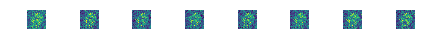

epoch: 0050   d_loss = 0.414784  g_loss = 3.030518


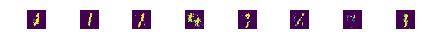

epoch: 0100   d_loss = 0.740519  g_loss = 1.979864


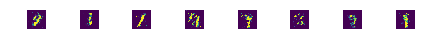

epoch: 0150   d_loss = 0.939821  g_loss = 1.490439


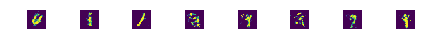

epoch: 0200   d_loss = 1.047131  g_loss = 1.292854


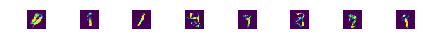

epoch: 0250   d_loss = 1.093325  g_loss = 1.191779


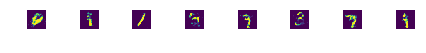

epoch: 0300   d_loss = 1.143632  g_loss = 1.106034


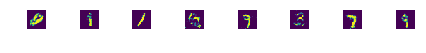

epoch: 0350   d_loss = 1.167252  g_loss = 1.058116


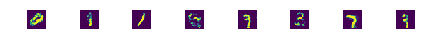

epoch: 0400   d_loss = 1.180853  g_loss = 1.040309


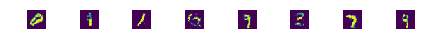

In [9]:
# training hyperparameters

n_epochs = 400
batch_size = 100
n_batches = int(mnist.train.num_examples / batch_size)

n_epochs_print = 50

with tf.Session() as tfs:
    tfs.run(tf.global_variables_initializer())
    for epoch in range(n_epochs+1):
        epoch_d_loss = 0.0
        epoch_g_loss = 0.0
        for batch in range(n_batches):
            x_batch, _ = mnist.train.next_batch(batch_size)
            x_batch = norm(x_batch)
            z_batch = np.random.uniform(-1.0,1.0,size=[batch_size,n_z])
            feed_dict = {x_p: x_batch,z_p: z_batch}
            _,batch_d_loss = tfs.run([d_train_op,d_loss], feed_dict=feed_dict)
            
            z_batch = np.random.uniform(-1.0,1.0,size=[batch_size,n_z])
            feed_dict={z_p: z_batch}
            _,batch_g_loss = tfs.run([g_train_op,g_loss], feed_dict=feed_dict)
            
            epoch_d_loss += batch_d_loss 
            epoch_g_loss += batch_g_loss
            
        if epoch%n_epochs_print == 0:
            average_d_loss = epoch_d_loss / n_batches
            average_g_loss = epoch_g_loss / n_batches
            print('epoch: {0:04d}   d_loss = {1:0.6f}  g_loss = {2:0.6f}'
                  .format(epoch,average_d_loss,average_g_loss))
            # predict images using generator model trained            
            x_pred = tfs.run(g_model,feed_dict={z_p:z_test})
            display_images(x_pred.reshape(-1,pixel_size,pixel_size))   
        

# Simple GAN in Keras

In [10]:
import keras
from keras.layers import Dense, Input, LeakyReLU, Dropout
from keras.models import Sequential, Model

In [11]:
tf.reset_default_graph()
keras.backend.clear_session()

In [12]:
# graph hyperparameters
g_learning_rate = 0.00001
d_learning_rate = 0.01

n_x = 784  # number of pixels in the MNIST image as number of inputs

# number of hidden layers for generator and discriminator
g_n_layers = 3
d_n_layers = 1
# neurons in each hidden layer
g_n_neurons = [256, 512, 1024]
d_n_neurons = [256]

# define generator

g_model = Sequential()
g_model.add(Dense(units=g_n_neurons[0], 
                  input_shape=(n_z,),
                  name='g_0'))
g_model.add(LeakyReLU())
for i in range(1,g_n_layers):
    g_model.add(Dense(units=g_n_neurons[i],
                      name='g_{}'.format(i)
                     ))
    g_model.add(LeakyReLU())
g_model.add(Dense(units=n_x, activation='tanh',name='g_out'))
print('Generator:')
g_model.summary()
g_model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(lr=g_learning_rate)
             )

# define discriminator

d_model = Sequential()
d_model.add(Dense(units=d_n_neurons[0],  
                  input_shape=(n_x,),
                  name='d_0'
                 ))
d_model.add(LeakyReLU())
d_model.add(Dropout(0.3))
for i in range(1,d_n_layers):
    d_model.add(Dense(units=d_n_neurons[i], 
                      name='d_{}'.format(i)
                     ))
    d_model.add(LeakyReLU())
    d_model.add(Dropout(0.3))
d_model.add(Dense(units=1, activation='sigmoid',name='d_out'))
print('Discriminator:')
d_model.summary()
d_model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.SGD(lr=d_learning_rate)
             )

# define GAN network
d_model.trainable=False
z_in = Input(shape=(n_z,),name='z_in')
x_in = g_model(z_in)
gan_out = d_model(x_in)

gan_model = Model(inputs=z_in,outputs=gan_out,name='gan')
print('GAN:')
gan_model.summary()
gan_model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(lr=g_learning_rate)
             )

Generator:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
g_0 (Dense)                  (None, 256)               65792     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
g_1 (Dense)                  (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
g_2 (Dense)                  (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
g_out (Dense)                (None, 784)               803600    

epoch: 0000   d_loss = 0.487638  g_loss = 0.890402


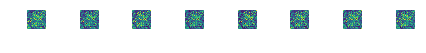

epoch: 0050   d_loss = 0.505144  g_loss = 1.377221


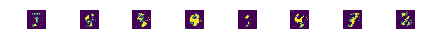

epoch: 0100   d_loss = 0.553929  g_loss = 1.212696


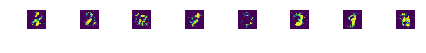

epoch: 0150   d_loss = 0.576929  g_loss = 1.128281


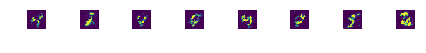

epoch: 0200   d_loss = 0.624352  g_loss = 0.968140


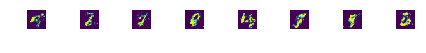

epoch: 0250   d_loss = 0.654071  g_loss = 0.849608


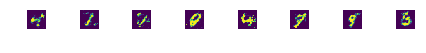

epoch: 0300   d_loss = 0.657199  g_loss = 0.825879


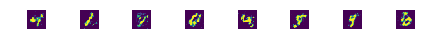

epoch: 0350   d_loss = 0.664721  g_loss = 0.799537


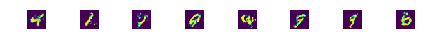

epoch: 0400   d_loss = 0.666603  g_loss = 0.792504


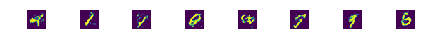

In [13]:
# training hyperparameters

n_epochs = 400
batch_size = 100
n_batches = int(mnist.train.num_examples / batch_size)
n_epochs_print = 50

for epoch in range(n_epochs+1):
    epoch_d_loss = 0.0
    epoch_g_loss = 0.0
    for batch in range(n_batches):
        x_batch, _ = mnist.train.next_batch(batch_size)
        x_batch = norm(x_batch)
        z_batch = np.random.uniform(-1.0,1.0,size=[batch_size,n_z])
        g_batch = g_model.predict(z_batch)
        
        x_in = np.concatenate([x_batch,g_batch])
        
        y_out = np.ones(batch_size*2)
        y_out[:batch_size]=0.9
        y_out[batch_size:]=0.1
        
        d_model.trainable=True
        batch_d_loss = d_model.train_on_batch(x_in,y_out)

        z_batch = np.random.uniform(-1.0,1.0,size=[batch_size,n_z])
        x_in=z_batch
        
        y_out = np.ones(batch_size)
            
        d_model.trainable=False
        batch_g_loss = gan_model.train_on_batch(x_in,y_out)
        
        epoch_d_loss += batch_d_loss 
        epoch_g_loss += batch_g_loss 
    if epoch%n_epochs_print == 0:
        average_d_loss = epoch_d_loss / n_batches
        average_g_loss = epoch_g_loss / n_batches
        print('epoch: {0:04d}   d_loss = {1:0.6f}  g_loss = {2:0.6f}'
              .format(epoch,average_d_loss,average_g_loss))
        # predict images using generator model trained            
        x_pred = g_model.predict(z_test)
        display_images(x_pred.reshape(-1,pixel_size,pixel_size))   